In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

In [14]:
data = pd.read_csv('D:/Carlson coursework/Sem 2/Predictive/Assignment 2/car.data', header=None)
data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'evaluation']
data

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Running Nested CV for Decision Tree...
Decision Tree: Mean Accuracy = 0.9703

Running Nested CV for Naïve Bayes...
Naïve Bayes: Mean Accuracy = 0.7004

Running Nested CV for KNN...
KNN: Mean Accuracy = 0.9349

Running Nested CV for Logistic Regression...
Logistic Regression: Mean Accuracy = 0.8278

Running Nested CV for SVM...
SVM: Mean Accuracy = 0.9812

Final Nested Cross-Validation Scores:
Decision Tree: 0.9703
Naïve Bayes: 0.7004
KNN: 0.9349
Logistic Regression: 0.8278
SVM: 0.9812

Fine-tuning Best Model (SVM) on Entire Training Data...

Best Model: SVM
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}

Final Model Performance on Test Set:
              precision    recall  f1-score   support

         acc       0.96      0.99      0.97        77
        good       1.00      1.00      1.00        14
       unacc       1.00      0.99      0.99       242
       vgood       1.00      1.00      1.00        13

    accuracy                           0.99       346

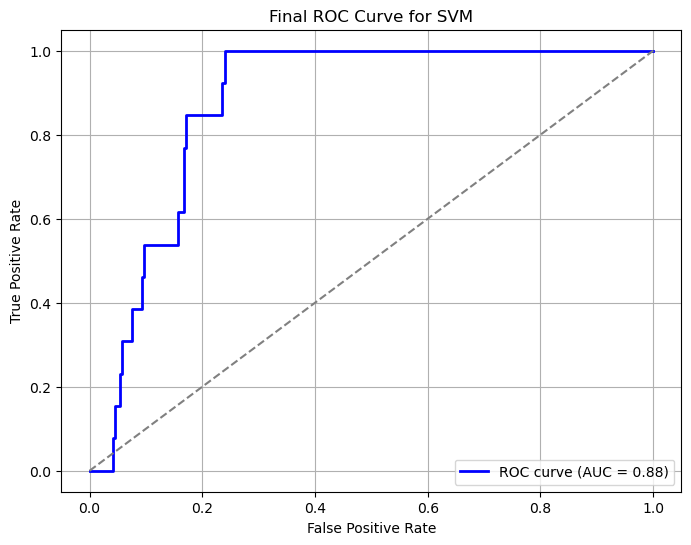

In [15]:
X = data.iloc[:, :-1]
y = data["evaluation"]

# Ordinal Encoding Transformer (specific order for ordinal encoding)
ordinal_categories = [
    ["low", "med", "high", "vhigh"],  # buying
    ["low", "med", "high", "vhigh"],  # maint
    ["2", "3", "4", "5more"],         # doors
    ["2", "4", "more"],               # persons
    ["small", "med", "big"],          # lug_boot
    ["low", "med", "high"]            # safety
]
ordinal_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(categories=ordinal_categories), X.columns)
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define models and parameter grids for tuning
models = {
    "Decision Tree": (Pipeline([("preprocessor", ordinal_transformer), ("classifier", DecisionTreeClassifier(random_state=42))]),
                    {"classifier__max_depth": [3, 5, 10], "classifier__criterion": ["gini", "entropy"]}),
    "Naïve Bayes": (Pipeline([("preprocessor", ordinal_transformer), ("classifier", GaussianNB())]), {}),
    "KNN": (Pipeline([("preprocessor", ordinal_transformer), ("classifier", KNeighborsClassifier())]),
            {"classifier__n_neighbors": [3, 5, 7], "classifier__weights": ["uniform", "distance"]}),
    "Logistic Regression": (Pipeline([("preprocessor", ordinal_transformer), ("classifier", LogisticRegression(max_iter=500))]),
                            {"classifier__C": [0.01, 0.1, 1, 10]}),
    "SVM": (Pipeline([("preprocessor", ordinal_transformer), ("classifier", SVC(probability=True))]),
            {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]})
}

# Perform Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
nested_scores = {}
best_model_name = None
best_score = 0
best_model_pipeline = None
best_params = None

for model_name, (pipeline, param_grid) in models.items():
    print(f"Running Nested CV for {model_name}...")
    
    # Inner loop: Hyperparameter tuning using GridSearchCV
    clf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1) if param_grid else pipeline
    
    # Outer loop: Performance evaluation using cross-validation
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=outer_cv, n_jobs=-1)
    
    # Store mean score
    nested_scores[model_name] = scores.mean()
    print(f"{model_name}: Mean Accuracy = {scores.mean():.4f}\n")
    
    # Track the best performing model
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model_name = model_name
        best_model_pipeline = pipeline  
        best_param_grid = param_grid  

# Display final nested CV results
print("Final Nested Cross-Validation Scores:")
for model, score in nested_scores.items():
    print(f"{model}: {score:.4f}")

# Perform GridSearchCV on the entire training set for the best model
print(f"\nFine-tuning Best Model ({best_model_name}) on Entire Training Data...")
final_grid_search = GridSearchCV(estimator=best_model_pipeline, param_grid=best_param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1)
final_grid_search.fit(X_train, y_train)

# Get the final best model
best_model = final_grid_search.best_estimator_
best_params = final_grid_search.best_params_

print(f"\nBest Model: {best_model_name}")
print(f"Best Hyperparameters: {best_params}")

# Evaluate performance on the test set
y_test_pred = best_model.predict(X_test)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs, pos_label="vgood")
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs, pos_label="vgood")

# Print final classification report
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Final ROC Curve for {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()


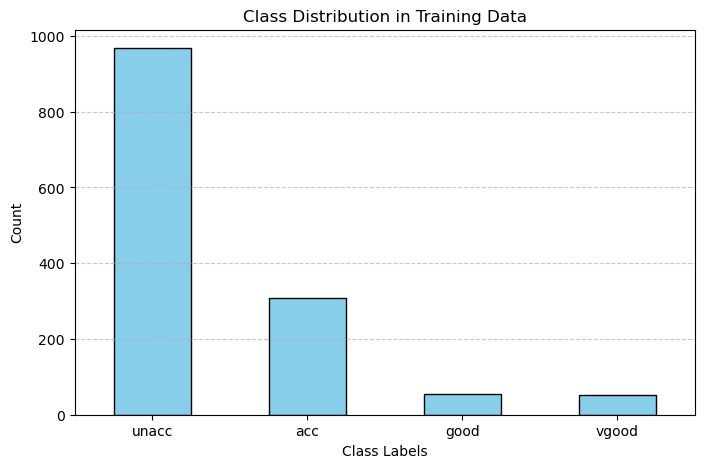

evaluation
unacc    70.043415
acc      22.214182
good      3.979740
vgood     3.762663
Name: count, dtype: float64

In [16]:
# Check class distribution in the dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'y_train' and 'y_test' contain the target labels
class_counts = y_train.value_counts()

# Plot class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Display class distribution percentages
class_distribution = class_counts / len(y_train) * 100
class_distribution


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

# Define feature-target split
X = data.iloc[:, :-1]
y = data["evaluation"]

# One-Hot Encoding Transformer
one_hot_transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(sparse_output=False), X.columns)
])

# Transform categorical features before applying SMOTE
X_encoded = one_hot_transformer.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Define models and parameter grids for tuning
models = {
    "Decision Tree": (Pipeline([("classifier", DecisionTreeClassifier(random_state=42))]),
                      {"classifier__max_depth": [3, 5, 10], "classifier__criterion": ["gini", "entropy"]}),
    "Naïve Bayes": (Pipeline([("classifier", GaussianNB())]), {}),
    "KNN": (Pipeline([("classifier", KNeighborsClassifier())]),
            {"classifier__n_neighbors": [3, 5, 7], "classifier__weights": ["uniform", "distance"]}),
    "Logistic Regression": (Pipeline([("classifier", LogisticRegression(max_iter=500))]),
                            {"classifier__C": [0.01, 0.1, 1, 10]}),
    "SVM": (Pipeline([("classifier", SVC(probability=True, class_weight='balanced'))]),
            {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]})
}

# Perform Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
nested_scores = {}
best_model_name = None
best_score = 0
best_model_pipeline = None
best_params = None

for model_name, (pipeline, param_grid) in models.items():
    print(f"Running Nested CV for {model_name}...")
    
    # Inner loop: Hyperparameter tuning using GridSearchCV
    clf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1) if param_grid else pipeline
    
    # Outer loop: Performance evaluation using cross-validation
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=outer_cv, n_jobs=-1)
    
    # Store mean score
    nested_scores[model_name] = scores.mean()
    print(f"{model_name}: Mean Accuracy = {scores.mean():.4f}\n")
    
    # Track the best performing model
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model_name = model_name
        best_model_pipeline = pipeline  
        best_param_grid = param_grid  

# Display final nested CV results
print("Final Nested Cross-Validation Scores:")
for model, score in nested_scores.items():
    print(f"{model}: {score:.4f}")

# Perform GridSearchCV on the entire training set for the best model
print(f"\nFine-tuning Best Model ({best_model_name}) on Entire Training Data...")
final_grid_search = GridSearchCV(estimator=best_model_pipeline, param_grid=best_param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1)
final_grid_search.fit(X_train, y_train)

# Get the final best model
best_model = final_grid_search.best_estimator_
best_params = final_grid_search.best_params_

print(f"\nBest Model: {best_model_name}")
print(f"Best Hyperparameters: {best_params}")

# Evaluate performance on the test set
y_test_pred = best_model.predict(X_test)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Print final classification report
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred))


Running Nested CV for Decision Tree...
Decision Tree: Mean Accuracy = 0.9595

Running Nested CV for Naïve Bayes...
Naïve Bayes: Mean Accuracy = 0.8017

Running Nested CV for KNN...
KNN: Mean Accuracy = 0.9031

Running Nested CV for Logistic Regression...
Logistic Regression: Mean Accuracy = 0.9233

Running Nested CV for SVM...
SVM: Mean Accuracy = 0.9964

Final Nested Cross-Validation Scores:
Decision Tree: 0.9595
Naïve Bayes: 0.8017
KNN: 0.9031
Logistic Regression: 0.9233
SVM: 0.9964

Fine-tuning Best Model (SVM) on Entire Training Data...

Best Model: SVM
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}

Final Model Performance on Test Set:
              precision    recall  f1-score   support

         acc       1.00      1.00      1.00        77
        good       1.00      1.00      1.00        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346

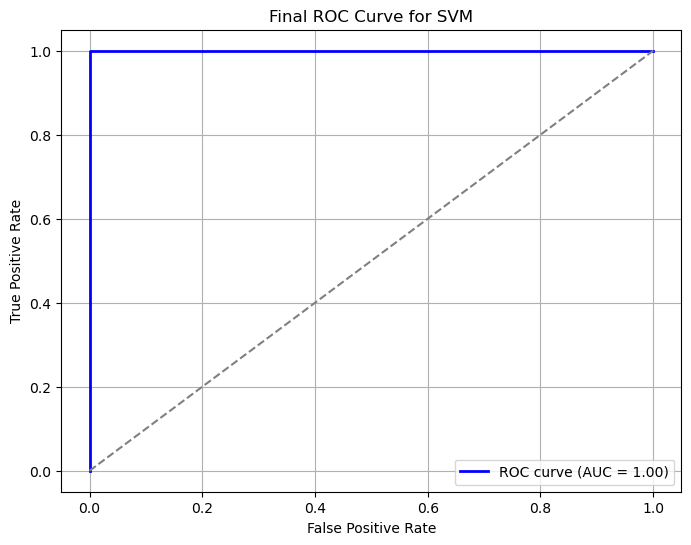

In [40]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs, pos_label="good")
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs, pos_label="good")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Final ROC Curve for {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()

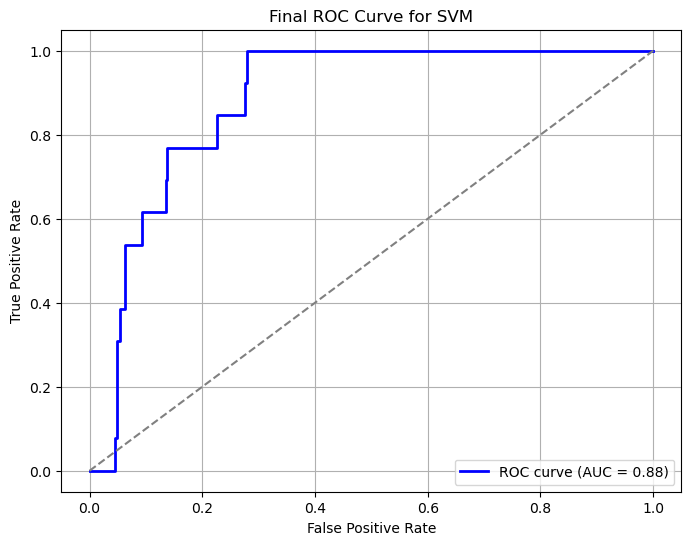

In [41]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs, pos_label="vgood")
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs, pos_label="vgood")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Final ROC Curve for {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_test_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Cross-Validation Std Dev: {cv_scores.std():.4f}")

from sklearn.metrics import roc_auc_score

train_probs = best_model.predict_proba(X_train)
test_probs = best_model.predict_proba(X_test)

train_auc = roc_auc_score(y_train, train_probs, multi_class="ovr")  # Use OvR for multi-class
test_auc = roc_auc_score(y_test, test_probs, multi_class="ovr")

print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
Cross-Validation Mean Accuracy: 0.9971
Cross-Validation Std Dev: 0.0035
Training AUC: 1.0000
Test AUC: 1.0000


In [45]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(max_iter=500)
baseline_model.fit(X_train, y_train)
baseline_acc = baseline_model.score(X_test, y_test)

print(f"Baseline Logistic Regression Accuracy: {baseline_acc:.4f}")


Baseline Logistic Regression Accuracy: 0.9017


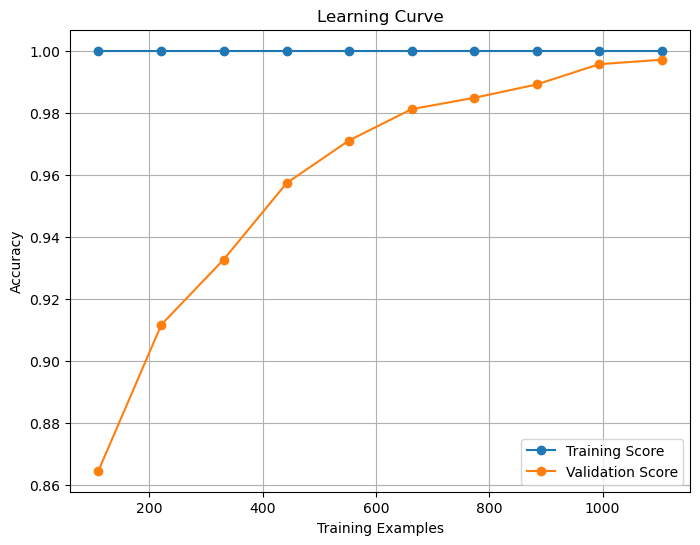

In [46]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training Score")
plt.plot(train_sizes, test_mean, "o-", label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
correlation_matrix = pd.DataFrame(X_encoded).corr()
print(correlation_matrix)


              0             1             2             3             4   \
0   1.000000e+00 -3.333333e-01 -3.333333e-01 -3.333333e-01  2.737008e-16   
1  -3.333333e-01  1.000000e+00 -3.333333e-01 -3.333333e-01 -2.330954e-16   
2  -3.333333e-01 -3.333333e-01  1.000000e+00 -3.333333e-01  7.084525e-17   
3  -3.333333e-01 -3.333333e-01 -3.333333e-01  1.000000e+00  1.201885e-16   
4   2.737008e-16 -2.330954e-16  7.084525e-17  1.201885e-16  1.000000e+00   
5   3.786409e-17  8.737866e-17 -1.745860e-16  1.593376e-17 -3.333333e-01   
6   2.733582e-16 -7.230156e-17 -1.429755e-16  3.212451e-17 -3.333333e-01   
7   4.431469e-16 -4.200172e-16  2.774701e-16 -1.489721e-16 -3.333333e-01   
8   9.423189e-19  2.912622e-17  2.337808e-16 -3.499430e-16 -4.463165e-17   
9  -8.129642e-17 -2.141634e-18  2.778128e-16 -2.183610e-16 -2.544261e-17   
10 -1.844375e-16  2.277842e-16  1.928327e-16 -2.529698e-16 -4.051971e-17   
11  7.829814e-17 -2.124501e-17 -1.536837e-16  1.002285e-16  8.566536e-18   
12  6.460339

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

# Define feature-target split
X = data.iloc[:, :-1]
y = data["evaluation"]

# One-Hot Encoding Transformer
one_hot_transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(sparse_output=False), X.columns)
])

# Transform categorical features before applying SMOTE
X_encoded = one_hot_transformer.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Define models and parameter grids for tuning
models = {
    "Decision Tree": (Pipeline([("classifier", DecisionTreeClassifier(random_state=42))]),
                      {"classifier__max_depth": [3, 5, 7], "classifier__criterion": ["gini", "entropy"]}),
    "Naïve Bayes": (Pipeline([("classifier", GaussianNB())]), {}),
    "KNN": (Pipeline([("classifier", KNeighborsClassifier())]),
            {"classifier__n_neighbors": [3, 5, 7], "classifier__weights": ["uniform", "distance"]}),
    "Logistic Regression": (Pipeline([("classifier", LogisticRegression(max_iter=500))]),
                            {"classifier__C": [0.01, 0.1, 1, 10]}),
    "SVM": (Pipeline([("classifier", SVC(probability=True, class_weight='balanced'))]),
            {"classifier__C": [0.01, 0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]})
}

# Perform Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
nested_scores = {}
best_model_name = None
best_score = 0
best_model_pipeline = None
best_params = None

for model_name, (pipeline, param_grid) in models.items():
    print(f"Running Nested CV for {model_name}...")
    
    # Inner loop: Hyperparameter tuning using GridSearchCV
    clf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1) if param_grid else pipeline
    
    # Outer loop: Performance evaluation using cross-validation
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=outer_cv, n_jobs=-1)
    
    # Store mean score
    nested_scores[model_name] = scores.mean()
    print(f"{model_name}: Mean Accuracy = {scores.mean():.4f}\n")
    
    # Track the best performing model
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model_name = model_name
        best_model_pipeline = pipeline  
        best_param_grid = param_grid  

# Display final nested CV results
print("Final Nested Cross-Validation Scores:")
for model, score in nested_scores.items():
    print(f"{model}: {score:.4f}")

# Perform GridSearchCV on the entire training set for the best model
print(f"\nFine-tuning Best Model ({best_model_name}) on Entire Training Data...")
final_grid_search = GridSearchCV(estimator=best_model_pipeline, param_grid=best_param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1)
final_grid_search.fit(X_train, y_train)

# Get the final best model
best_model = final_grid_search.best_estimator_
best_params = final_grid_search.best_params_

print(f"\nBest Model: {best_model_name}")
print(f"Best Hyperparameters: {best_params}")

# Evaluate performance on the test set
y_test_pred = best_model.predict(X_test)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Print final classification report
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred))


Running Nested CV for Decision Tree...
Decision Tree: Mean Accuracy = 0.9189

Running Nested CV for Naïve Bayes...
Naïve Bayes: Mean Accuracy = 0.8017

Running Nested CV for KNN...
KNN: Mean Accuracy = 0.9031

Running Nested CV for Logistic Regression...
Logistic Regression: Mean Accuracy = 0.9233

Running Nested CV for SVM...
SVM: Mean Accuracy = 0.9964

Final Nested Cross-Validation Scores:
Decision Tree: 0.9189
Naïve Bayes: 0.8017
KNN: 0.9031
Logistic Regression: 0.9233
SVM: 0.9964

Fine-tuning Best Model (SVM) on Entire Training Data...

Best Model: SVM
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}

Final Model Performance on Test Set:
              precision    recall  f1-score   support

         acc       1.00      1.00      1.00        77
        good       1.00      1.00      1.00        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346

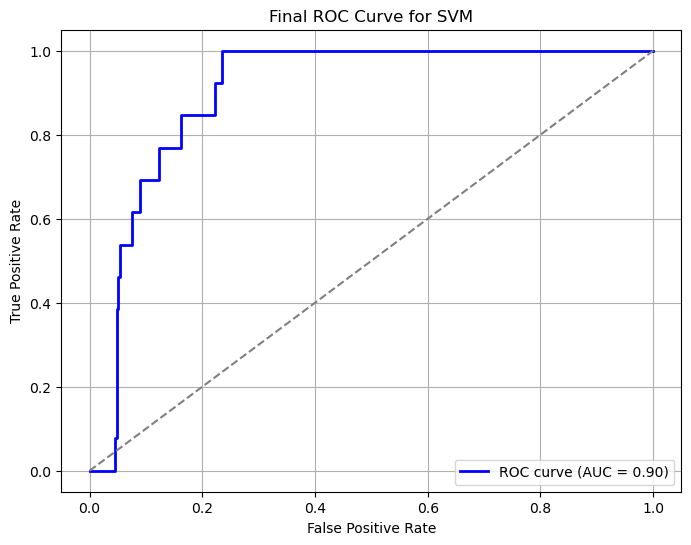

In [49]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs, pos_label="vgood")
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs, pos_label="vgood")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Final ROC Curve for {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()

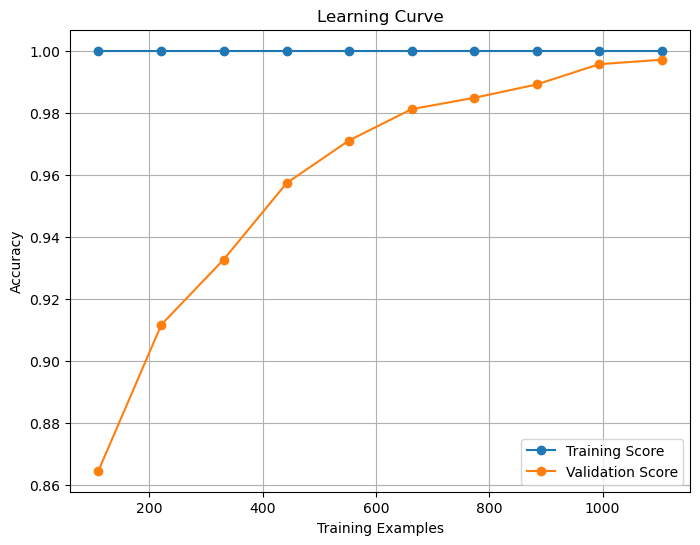

In [50]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training Score")
plt.plot(train_sizes, test_mean, "o-", label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


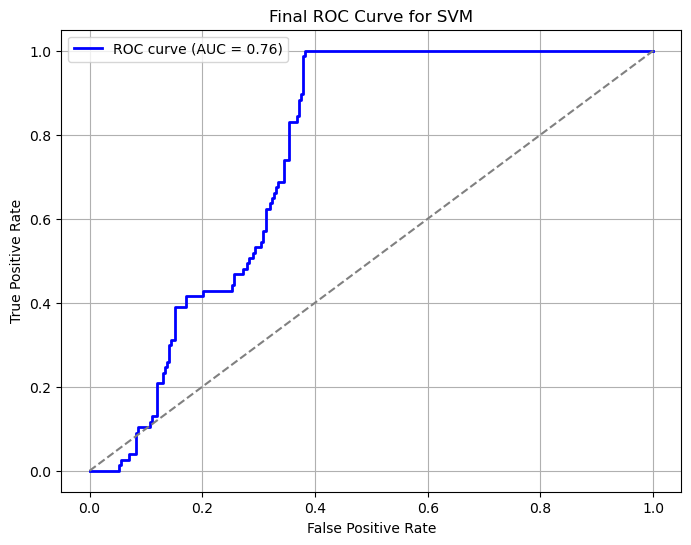

In [52]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs, pos_label="acc")
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs, pos_label="acc")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Final ROC Curve for {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()